# Board Game Text Analysis

In [1]:

#install.packages("tidytext")
#install.packages("textdata")
#install.packages("RSQLite")
#install.packages("fivethirtyeight")
#install.packages("forcats")
#install.packages("rsample")
#install.packages("rpart.plot")

library(broom, quietly = TRUE, warn.conflicts = FALSE)
library(forcats, quietly = TRUE, warn.conflicts = FALSE)
library(rpart.plot, quietly = TRUE, warn.conflicts = FALSE)
library(rsample, quietly = TRUE, warn.conflicts = FALSE)
library(tidyr, quietly = TRUE, warn.conflicts = FALSE)
library(fivethirtyeight, quietly = TRUE, warn.conflicts = FALSE)
library(RSQLite, quietly = TRUE, warn.conflicts = FALSE)
library(DBI, quietly = TRUE, warn.conflicts = FALSE)
library(ggplot2, quietly = TRUE, warn.conflicts = FALSE)
library(dplyr, quietly = TRUE, warn.conflicts = FALSE)
library(readr, quietly = TRUE, warn.conflicts = FALSE)
library(tidytext, quietly = TRUE, warn.conflicts = FALSE)
library(textdata, quietly = TRUE, warn.conflicts = FALSE)
library(stringr, quietly = TRUE, warn.conflicts = FALSE)
library(lubridate, quietly = TRUE, warn.conflicts = FALSE)
library(knitr, quietly = TRUE, warn.conflicts = FALSE)
library(hunspell, quietly = TRUE, warn.conflicts = FALSE)
library(rpart, quietly = TRUE, warn.conflicts = FALSE)
options(scipen = 99)


Warning message:
"package 'forcats' was built under R version 3.6.2"Warning message:
"package 'rpart.plot' was built under R version 3.6.2"Warning message:
"package 'rsample' was built under R version 3.6.2"Warning message:
"package 'fivethirtyeight' was built under R version 3.6.2"Warning message:
"package 'RSQLite' was built under R version 3.6.2"Warning message:
"package 'DBI' was built under R version 3.6.2"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"package 'tidytext' was built under R version 3.6.2"Warning message:
"package 'textdata' was built under R version 3.6.2"Warning message:
"package 'hunspell' was built under R version 3.6.2"

In [2]:
bgames = dbConnect(RSQLite::SQLite(), "database.sqlite")

In [3]:
alltables = dbListTables(bgames)
p1 = dbGetQuery( bgames,'select * from BoardGames limit 1000' )

p1 <- p1 %>%  filter(game.id !=680)
p1 <- p1 %>% filter(game.id !=63)

In [4]:
my_hunspell_stem <- function(token) {
  stem_token <- hunspell_stem(token)[[1]]
  if (length(stem_token) == 0) return(token) else return(stem_token[1])
}
vec_hunspell_stem <- Vectorize(my_hunspell_stem, "token")


In [5]:
desc_tokens <- p1 %>% 
  mutate(details.description = str_replace_all(details.description, 
                                pattern=regex("(www|https?[^\\s]+)"), 
                                replacement = "")) %>% #rm urls
  mutate(details.description = str_replace_all(details.description,
                                pattern = "[[:digit:]]",
                                replacement = "")) %>% 
  unnest_tokens(tokens, details.description) %>% #tokenize
  mutate(tokens = vec_hunspell_stem(tokens)) %>% 
  filter(!(tokens %in% stop_words$word)) #rm stopwords

## Sentiment Analysis

In [6]:
afinn_sentiment <- system.file("extdata", "afinn.csv", package = "fivethirtyeight") %>% 
  read_csv()

desc_sentiment <- desc_tokens %>% 
  inner_join(afinn_sentiment, by=c("tokens"="word")) 

desc_comb <- desc_sentiment %>% 
  group_by(game.id) %>% 
  summarise(score = sum(value, na.rm=TRUE)) %>% 
  ungroup() %>% 
  right_join(p1, by="game.id")


Parsed with column specification:
cols(
  word = col_character(),
  value = col_double()
)


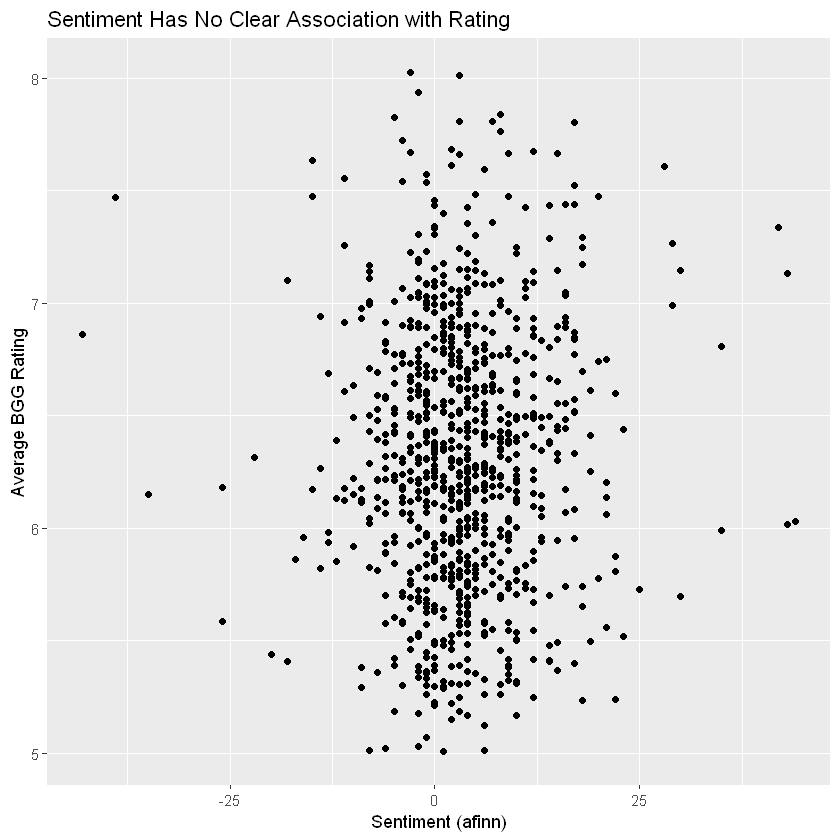

In [7]:
sentOverTimeGraph <- ggplot(data=filter(desc_comb,!is.na(score) & stats.average>5 ), aes(x=score, y=stats.average)) +
  geom_point() +
  ylab("Average BGG Rating") +
  xlab("Sentiment (afinn)") +
  ggtitle("Sentiment Has No Clear Association with Rating")
sentOverTimeGraph

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


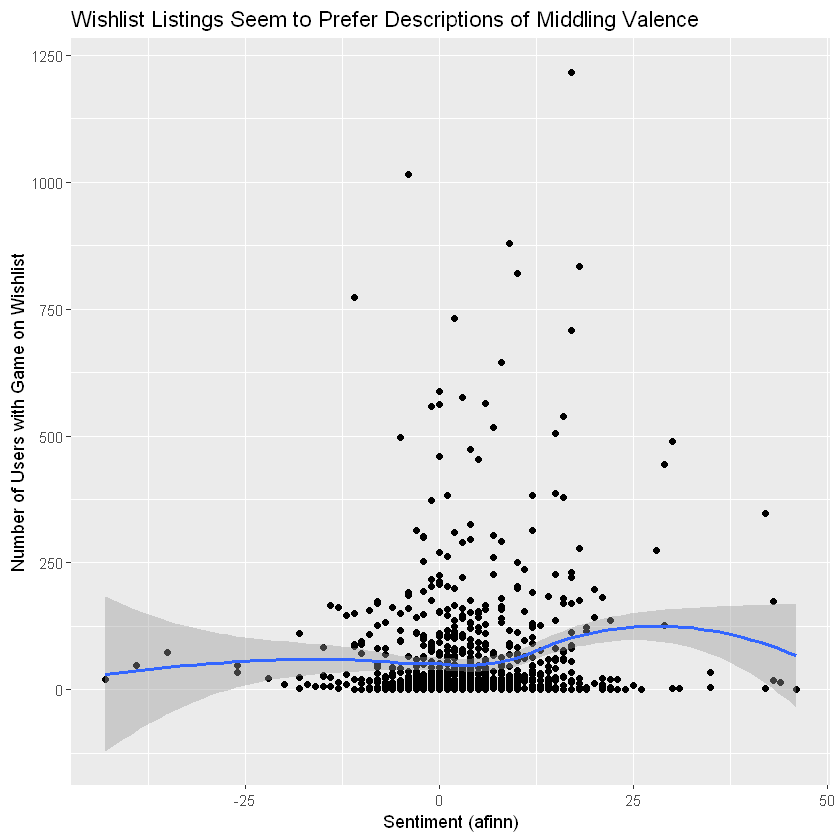

In [8]:
WantOverSentGraph <- ggplot(data=filter(desc_comb,!is.na(score)), aes(y=stats.wanting, x=score)) +
  geom_point() +
  ylab("Number of Users with Game on Wishlist") +
  xlab("Sentiment (afinn)") +
  geom_smooth()+
  ggtitle("Wishlist Listings Seem to Prefer Descriptions of Middling Valence")
WantOverSentGraph